# Exploring OLS, Lasso and Random Forest in a regression task.


In [1]:
#adopted from github.com/Yorko/mlcourse.ai/

In [2]:
import warnings

warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso, LassoCV, LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import (GridSearchCV, cross_val_score,
                                     train_test_split, RandomizedSearchCV)
from sklearn.preprocessing import StandardScaler
import seaborn as sns

**We are working with UCI Wine quality dataset**

In [3]:
data = pd.read_csv("winequality-white.csv", sep=";")

In [4]:
data.head()

fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.0              0.27         0.36            20.7      0.045   
1            6.3              0.30         0.34             1.6      0.049   
2            8.1              0.28         0.40             6.9      0.050   
3            7.2              0.23         0.32             8.5      0.058   
4            7.2              0.23         0.32             8.5      0.058   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 45.0                 170.0   1.0010  3.00       0.45   
1                 14.0                 132.0   0.9940  3.30       0.49   
2                 30.0                  97.0   0.9951  3.26       0.44   
3                 47.0                 186.0   0.9956  3.19       0.40   
4                 47.0                 186.0   0.9956  3.19       0.40   

   alcohol  quality  
0      8.8        6  
1      9.5        6  
2     10.1        6  
3      9.9        6  
4      9.9        6

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4898 entries, 0 to 4897
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         4898 non-null   float64
 1   volatile acidity      4898 non-null   float64
 2   citric acid           4898 non-null   float64
 3   residual sugar        4898 non-null   float64
 4   chlorides             4898 non-null   float64
 5   free sulfur dioxide   4898 non-null   float64
 6   total sulfur dioxide  4898 non-null   float64
 7   density               4898 non-null   float64
 8   pH                    4898 non-null   float64
 9   sulphates             4898 non-null   float64
 10  alcohol               4898 non-null   float64
 11  quality               4898 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 459.3 KB


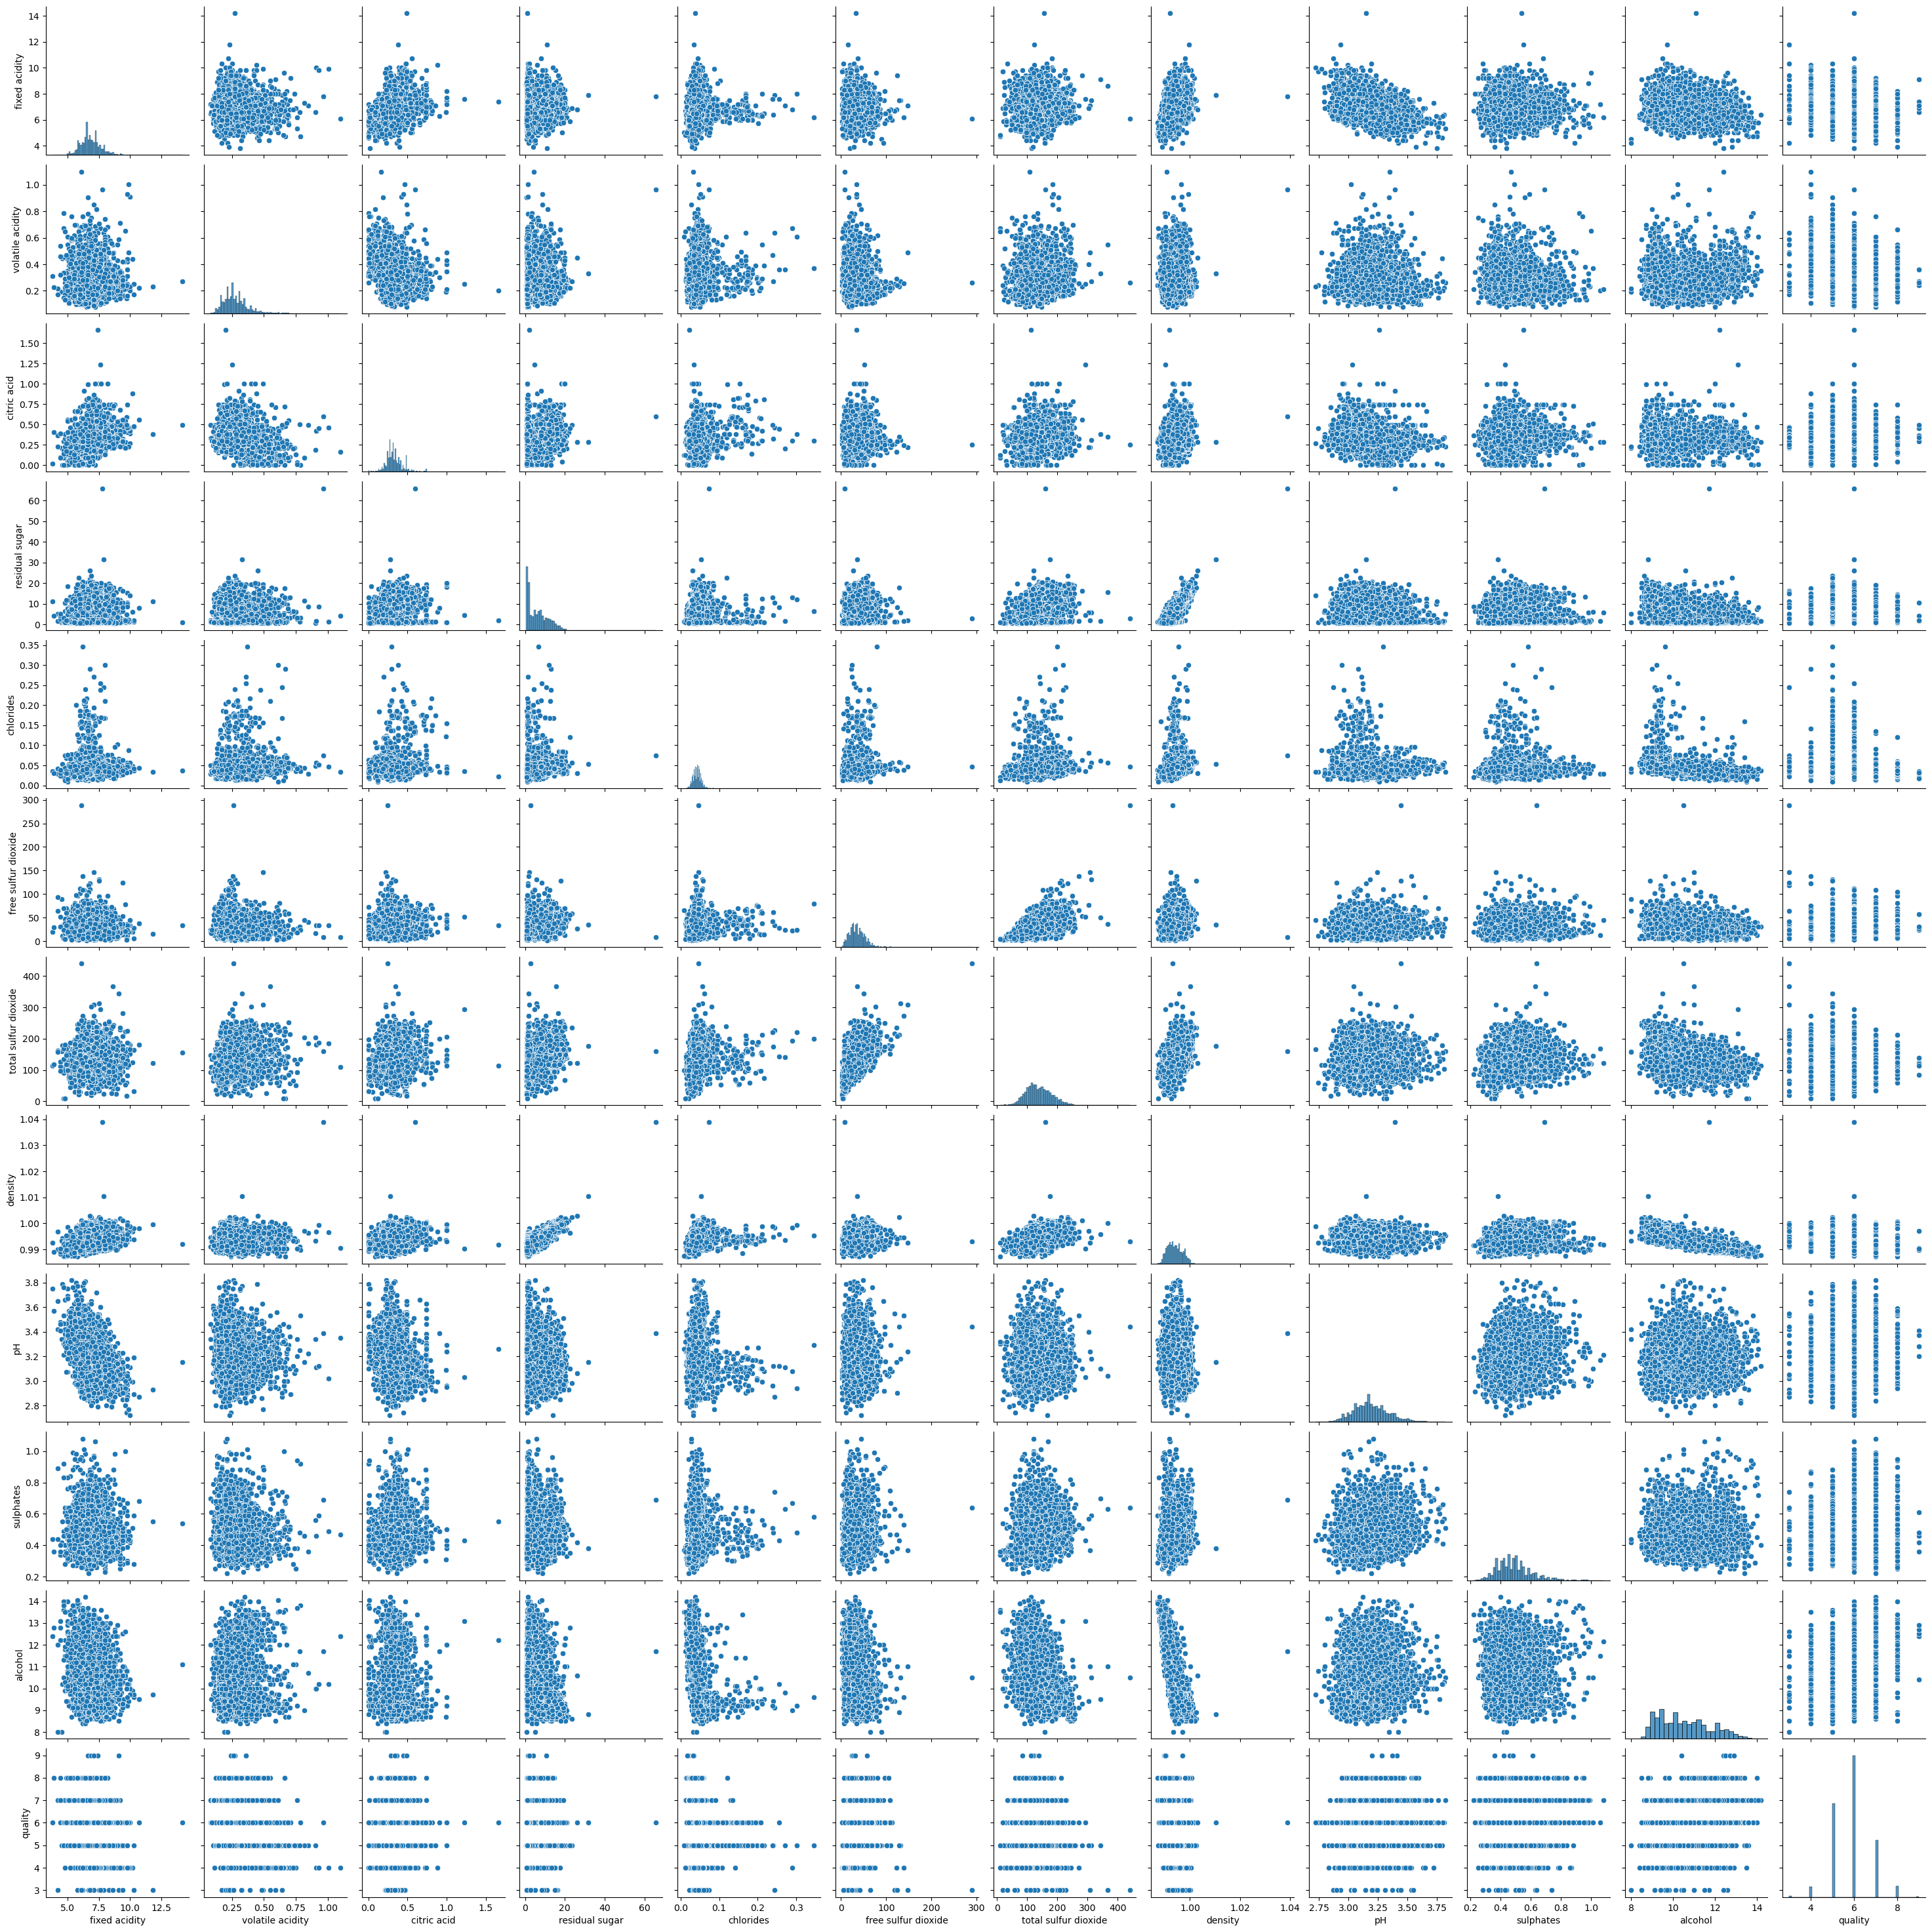

In [6]:
sns.pairplot(data)

<Axes: >

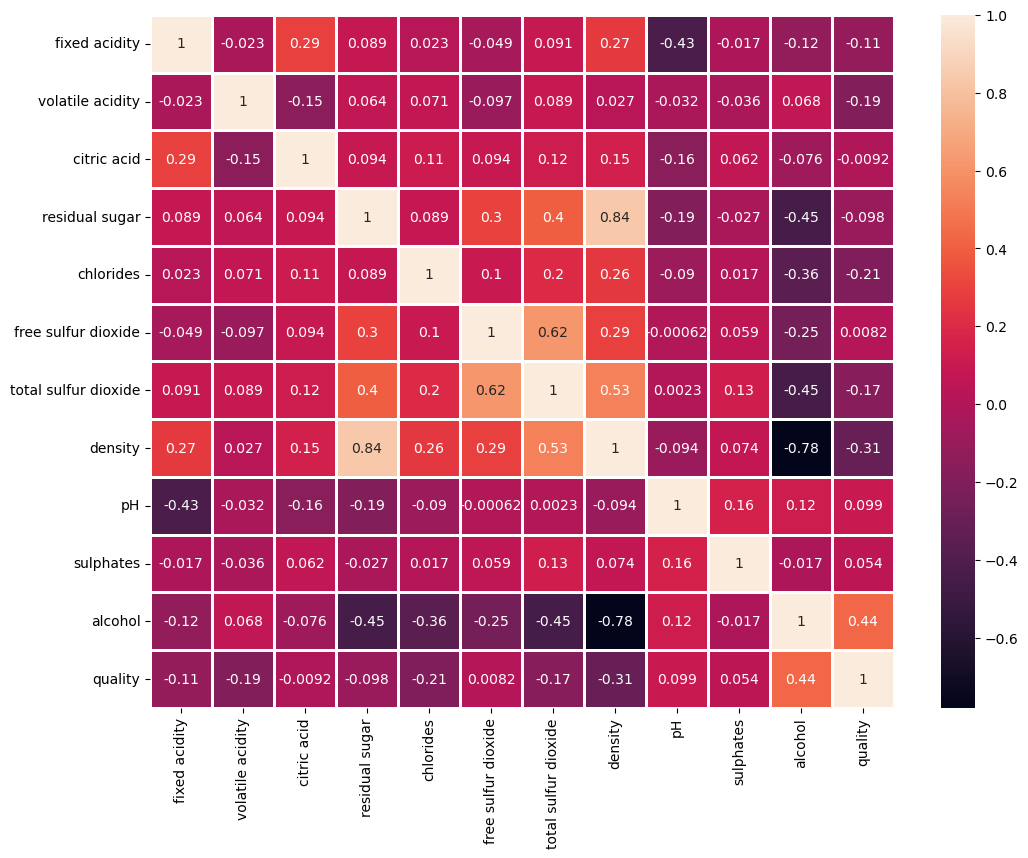

In [7]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,9))
sns.heatmap(data.corr(),annot=True,linewidths=2)

**Separate the target feature, split data in 7:3 proportion (30% form a holdout set, use random_state=17), and preprocess data with `StandardScaler`.**

In [7]:
y = data["quality"]
X = data.drop("quality", axis=1)

X_train, X_holdout, y_train, y_holdout = train_test_split(
    X, y, test_size=0.3, random_state=17
)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_holdout_scaled = scaler.transform(X_holdout)

## Linear regression

**Train a simple linear regression model (Ordinary Least Squares).**

In [8]:
linreg = LinearRegression()
linreg.fit(X_train_scaled, y_train);

**What are mean squared errors of model predictions on train and holdout sets?**

In [9]:
print(
    "Mean squared error (train): %.3f"
    % mean_squared_error(y_train, linreg.predict(X_train_scaled))
)
print(
    "Mean squared error (test): %.3f"
    % mean_squared_error(y_holdout, linreg.predict(X_holdout_scaled))
)

Mean squared error (train): 0.558
Mean squared error (test): 0.584


In [10]:
from sklearn.metrics import r2_score

#print("R-squared value of predictions:",round(metrics.r2_score(y_test,predictions),3))
print(
    "R-squared value  (train): %.3f"
    % round(r2_score(y_train, linreg.predict(X_train_scaled)),3)
)
print(
    "R-squared value  (test): %.3f"
    % round(r2_score(y_holdout, linreg.predict(X_holdout_scaled)),3)
)

R-squared value  (train): 0.290
R-squared value  (test): 0.250


**Sort features by their influence on the target feature (wine quality). Beware that both large positive and large negative coefficients mean large influence on target. It's handy to use `pandas.DataFrame` here.**

Which feature this linear regression model treats as the most influential on wine quality?

In [11]:
linreg_coef = pd.DataFrame(
    {"coef": linreg.coef_, "coef_abs": np.abs(linreg.coef_)},
    index=data.columns.drop("quality"),
)
linreg_coef.sort_values(by="coef_abs", ascending=False)

coef  coef_abs
density              -0.665720  0.665720
residual sugar        0.538164  0.538164
volatile acidity     -0.192260  0.192260
pH                    0.150036  0.150036
alcohol               0.129533  0.129533
fixed acidity         0.097822  0.097822
sulphates             0.062053  0.062053
free sulfur dioxide   0.042180  0.042180
total sulfur dioxide  0.014304  0.014304
chlorides             0.008127  0.008127
citric acid          -0.000183  0.000183

## Lasso regression

**Train a LASSO model with $\alpha = 0.01$ (weak regularization) and scaled data. Again, set random_state=17.**

In [27]:
lasso1 = Lasso(alpha=0.01, random_state=17)
lasso1.fit(X_train_scaled, y_train)

Lasso(alpha=0.01, random_state=17)

**Which feature is the least informative in predicting wine quality, according to this LASSO model?**

In [28]:
lasso1_coef = pd.DataFrame(
    {"coef": lasso1.coef_, "coef_abs": np.abs(lasso1.coef_)},
    index=data.columns.drop("quality"),
)
lasso1_coef.sort_values(by="coef_abs", ascending=False)

coef  coef_abs
alcohol               0.322425  0.322425
residual sugar        0.256363  0.256363
density              -0.235492  0.235492
volatile acidity     -0.188479  0.188479
pH                    0.067277  0.067277
free sulfur dioxide   0.043088  0.043088
sulphates             0.029722  0.029722
chlorides            -0.002747  0.002747
fixed acidity        -0.000000  0.000000
citric acid          -0.000000  0.000000
total sulfur dioxide -0.000000  0.000000

In [29]:
print(
    "Mean squared error (train): %.3f"
    % mean_squared_error(y_train, lasso1.predict(X_train_scaled))
)
print(
    "Mean squared error (test): %.3f"
    % mean_squared_error(y_holdout, lasso1.predict(X_holdout_scaled))
)

Mean squared error (train): 0.564
Mean squared error (test): 0.574


In [30]:
from sklearn.metrics import r2_score

#print("R-squared value of predictions:",round(metrics.r2_score(y_test,predictions),3))
print(
    "R-squared value  (train): %.3f"
    % round(r2_score(y_train, lasso1.predict(X_train_scaled)),3)
)
print(
    "R-squared value  (test): %.3f"
    % round(r2_score(y_holdout, lasso1.predict(X_holdout_scaled)),3)
)

R-squared value  (train): 0.283
R-squared value  (test): 0.263


**Train LassoCV with random_state=17 to choose the best value of $\alpha$ in 5-fold cross-validation.**

In [31]:
#alphas = np.logspace(-6, 2, 200)
#alphas

In [32]:
alphas = np.logspace(-6, 2, 200)
lasso_cv = LassoCV(random_state=17, cv=5, alphas=alphas)
lasso_cv.fit(X_train_scaled, y_train)

LassoCV(alphas=array([1.00000000e-06, 1.09698580e-06, 1.20337784e-06, 1.32008840e-06,
       1.44811823e-06, 1.58856513e-06, 1.74263339e-06, 1.91164408e-06,
       2.09704640e-06, 2.30043012e-06, 2.52353917e-06, 2.76828663e-06,
       3.03677112e-06, 3.33129479e-06, 3.65438307e-06, 4.00880633e-06,
       4.39760361e-06, 4.82410870e-06, 5.29197874e-06, 5.80522552e-06,
       6.36824994e-06, 6.98587975e-0...
       1.18953407e+01, 1.30490198e+01, 1.43145894e+01, 1.57029012e+01,
       1.72258597e+01, 1.88965234e+01, 2.07292178e+01, 2.27396575e+01,
       2.49450814e+01, 2.73644000e+01, 3.00183581e+01, 3.29297126e+01,
       3.61234270e+01, 3.96268864e+01, 4.34701316e+01, 4.76861170e+01,
       5.23109931e+01, 5.73844165e+01, 6.29498899e+01, 6.90551352e+01,
       7.57525026e+01, 8.30994195e+01, 9.11588830e+01, 1.00000000e+02]),
        cv=5, random_state=17)

In [33]:
lasso_cv.alpha_

0.0002833096101839324

**Which feature is the least informative in predicting wine quality, according to the tuned LASSO model?**

In [34]:
lasso_cv_coef = pd.DataFrame(
    {"coef": lasso_cv.coef_, "coef_abs": np.abs(lasso_cv.coef_)},
    index=data.columns.drop("quality"),
)
lasso_cv_coef.sort_values(by="coef_abs", ascending=False)

coef  coef_abs
density              -0.648161  0.648161
residual sugar        0.526883  0.526883
volatile acidity     -0.192049  0.192049
pH                    0.146549  0.146549
alcohol               0.137115  0.137115
fixed acidity         0.093295  0.093295
sulphates             0.060939  0.060939
free sulfur dioxide   0.042698  0.042698
total sulfur dioxide  0.012969  0.012969
chlorides             0.006933  0.006933
citric acid          -0.000000  0.000000

**What are mean squared errors of tuned LASSO predictions on train and holdout sets?**

In [25]:
print(
    "Mean squared error (train): %.3f"
    % mean_squared_error(y_train, lasso_cv.predict(X_train_scaled))
)
print(
    "Mean squared error (test): %.3f"
    % mean_squared_error(y_holdout, lasso_cv.predict(X_holdout_scaled))
)

Mean squared error (train): 0.558
Mean squared error (test): 0.583


In [26]:
print(
    "R-squared value  (train): %.3f"
    % round(r2_score(y_train, lasso_cv.predict(X_train_scaled)),3)
)
print(
    "R-squared value  (test): %.3f"
    % round(r2_score(y_holdout, lasso_cv.predict(X_holdout_scaled)),3)
)

R-squared value  (train): 0.290
R-squared value  (test): 0.251


## Random Forest

**Train a Random Forest with out-of-the-box parameters, setting only random_state to be 17.**

In [39]:
forest = RandomForestRegressor(n_estimators=50, random_state=17)
forest.fit(X_train_scaled, y_train)

RandomForestRegressor(n_estimators=50, random_state=17)

**What are mean squared errors of RF model on the training set, in cross-validation (cross_val_score with scoring='neg_mean_squared_error' and other arguments left with default values) and on holdout set?**

In [40]:
print(
    "Mean squared error (train): %.3f"
    % mean_squared_error(y_train, forest.predict(X_train_scaled))
)
print(
    "Mean squared error (cv): %.3f"
    % np.mean(
        np.abs(
            cross_val_score(
                forest, X_train_scaled, y_train, scoring="neg_mean_squared_error"
            )
        )
    )
)
print(
    "Mean squared error (test): %.3f"
    % mean_squared_error(y_holdout, forest.predict(X_holdout_scaled))
)

Mean squared error (train): 0.055
Mean squared error (cv): 0.419
Mean squared error (test): 0.374


**Tune the `max_features` and `max_depth` hyperparameters with GridSearchCV and again check mean cross-validation MSE and MSE on holdout set.**

In [41]:
forest_params = {"max_depth": list(range(10, 25)), "max_features": list(range(6, 12))}

locally_best_forest = GridSearchCV(
    RandomForestRegressor(n_jobs=-1, random_state=17),
    forest_params,
    scoring="neg_mean_squared_error",
    n_jobs=-1,
    cv=5,
    verbose=True,
)
locally_best_forest.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 90 candidates, totalling 450 fits


GridSearchCV(cv=5, estimator=RandomForestRegressor(n_jobs=-1, random_state=17),
             n_jobs=-1,
             param_grid={'max_depth': [10, 11, 12, 13, 14, 15, 16, 17, 18, 19,
                                       20, 21, 22, 23, 24],
                         'max_features': [6, 7, 8, 9, 10, 11]},
             scoring='neg_mean_squared_error', verbose=True)

In [42]:
locally_best_forest.best_params_, locally_best_forest.best_score_

({'max_depth': 21, 'max_features': 6}, -0.39773288191505934)

**What are mean squared errors of tuned RF model in cross-validation (cross_val_score with scoring='neg_mean_squared_error' and other arguments left with default values) and on holdout set?**

In [43]:
print(
    "Mean squared error (cv): %.3f"
    % np.mean(
        np.abs(
            cross_val_score(
                locally_best_forest.best_estimator_,
                X_train_scaled,
                y_train,
                scoring="neg_mean_squared_error",
            )
        )
    )
)
print(
    "Mean squared error (test): %.3f"
    % mean_squared_error(y_holdout, locally_best_forest.predict(X_holdout_scaled))
)

Mean squared error (cv): 0.398
Mean squared error (test): 0.366


In [44]:
print(
    "r2_score (cv): %.3f"
    % np.mean(
        np.abs(
            cross_val_score(
                locally_best_forest.best_estimator_,
                X_train_scaled,
                y_train,
                scoring="r2",
            )
        )
    )
)
print(
    "R-squared value (test): %.3f"
    % r2_score(y_holdout, locally_best_forest.predict(X_holdout_scaled))
)

r2_score (cv): 0.494
R-squared value (test): 0.530


In [45]:
import sklearn.metrics as metrics
metrics.get_scorer_names()

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'matthews_corrcoef',
 'max_error',
 'mutual_info_score',
 'neg_brier_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_absolute_percentage_error',
 'neg_mean_gamma_deviance',
 'neg_mean_poisson_deviance',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'neg_negative_likelihood_ratio',
 'neg_root_mean_squared_error',
 'normalized_mutual_info_score',
 'positive_likelihood_ratio',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'rand_score',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',

**Output RF's feature importance. Again, it's nice to present it as a DataFrame.**<br>
**What is the most important feature, according to the Random Forest model?**

In [39]:
rf_importance = pd.DataFrame(
    locally_best_forest.best_estimator_.feature_importances_,
    columns=["coef"],
    index=data.columns[:-1],
)
rf_importance.sort_values(by="coef", ascending=False)

coef
alcohol               0.206056
volatile acidity      0.117578
free sulfur dioxide   0.111556
density               0.088549
pH                    0.073659
total sulfur dioxide  0.073640
chlorides             0.073366
residual sugar        0.072072
citric acid           0.062601
fixed acidity         0.061813
sulphates             0.059111

In [57]:
forest_params = {"n_estimators": list(range(10,1000,40)), "max_depth": list(range(10, 25)), "max_features": list(range(6, 12))}

locally_best_forest_R = RandomizedSearchCV(
    RandomForestRegressor(n_jobs=-1, random_state=17),
    forest_params,
    scoring="r2",
    n_jobs=-1,
    cv=5,
    verbose=True,
)
locally_best_forest_R.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5,
                   estimator=RandomForestRegressor(n_jobs=-1, random_state=17),
                   n_jobs=-1,
                   param_distributions={'max_depth': [10, 11, 12, 13, 14, 15,
                                                      16, 17, 18, 19, 20, 21,
                                                      22, 23, 24],
                                        'max_features': [6, 7, 8, 9, 10, 11],
                                        'n_estimators': [10, 50, 90, 130, 170,
                                                         210, 250, 290, 330,
                                                         370, 410, 450, 490,
                                                         530, 570, 610, 650,
                                                         690, 730, 770, 810,
                                                         850, 890, 930, 970]},
                   scoring='r2', verbose=True)

In [58]:
locally_best_forest_R.best_params_, locally_best_forest.best_score_

({'n_estimators': 810, 'max_features': 6, 'max_depth': 23},
 -0.39773288191505934)

In [59]:
print(
    "Mean squared error (cv): %.3f"
    % np.mean(
        np.abs(
            cross_val_score(
                locally_best_forest_R.best_estimator_,
                X_train_scaled,
                y_train,
                scoring="neg_mean_squared_error",
            )
        )
    )
)
print(
    "Mean squared error (test): %.3f"
    % mean_squared_error(y_holdout, locally_best_forest_R.predict(X_holdout_scaled))
)

Mean squared error (cv): 0.397
Mean squared error (test): 0.363


In [60]:
print(
    "r2_score (cv): %.3f"
    % np.mean(
        np.abs(
            cross_val_score(
                locally_best_forest_R.best_estimator_,
                X_train_scaled,
                y_train,
                scoring="r2",
            )
        )
    )
)
print(
    "R-squared value (test): %.3f"
    % r2_score(y_holdout, locally_best_forest_R.predict(X_holdout_scaled))
)

r2_score (cv): 0.495
R-squared value (test): 0.534


In [61]:
rf_importance = pd.DataFrame(
    locally_best_forest_R.best_estimator_.feature_importances_,
    columns=["coef"],
    index=data.columns[:-1],
)
rf_importance.sort_values(by="coef", ascending=False)

coef
alcohol               0.200113
volatile acidity      0.116546
free sulfur dioxide   0.110798
density               0.096304
total sulfur dioxide  0.073346
residual sugar        0.073026
pH                    0.072800
chlorides             0.072766
fixed acidity         0.063677
citric acid           0.061579
sulphates             0.059046

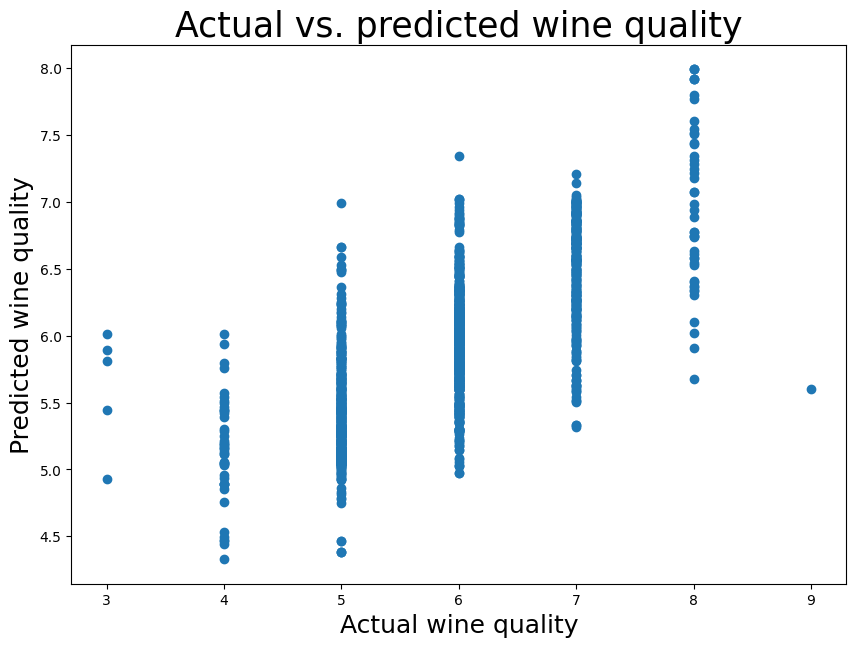

In [62]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,7))
plt.title("Actual vs. predicted wine quality",fontsize=25)
plt.xlabel("Actual wine quality",fontsize=18)
plt.ylabel("Predicted wine quality", fontsize=18)
plt.scatter(x=y_holdout,y=locally_best_forest_R.predict(X_holdout_scaled))